In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()
from matplotlib import dates
import math
from matplotlib import dates
from astropy.time import Time

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
plt.style.use('seaborn-dark-palette')

In [43]:
sith = pd.read_csv('Jedi_Demon_Additional_Data.csv', low_memory=False)

In [44]:
sith.head(1)

,Event #,GOES Flare Start Time,GOES Flare Peak Time,GOES Flare Time to Peak In Sec,GOES Flare Class,Flare Class Converted,Pre-Flare Start Time,Quad Depth [%],Pre-Flare End Time,Flare Interrupt,...,103.2 by 102.6 Fitting Score,Has DEMON Dimming,Intensity,Max Drop,Demon Event #,Demon Flare,Fraction of dimming on disk,Fractional size of off-limb dimming contribution,Is Off-Limb,Off-Limb Percent
0,1.0,2010-05-04 16:15:00.000,2010-05-04 16:29:00.000,840.0,C3.6,360,2010-05-04 08:29:00.000,0.0,2010-05-04 16:29:00.000,True,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN


In [45]:
sith.loc[:, '21.1 Duration [s]'].count()

75

In [46]:
def turnIntoSeconds_jedi_demon(timeArray):
    secondArray = []
    
    for i in range(len (timeArray)):
        timeValue = timeArray[i]
        if(str(timeValue) != 'nan'):
            hours = timeValue[11:13]
            minutes = timeValue[14:16]
            seconds = timeValue[17:19]

            secondHours = round(float(hours) * 60 * 60)
            minuteHours = round(float(minutes) * 60)
            secondFloat = float(seconds)

            secondArray.append((secondHours + minuteHours + secondFloat))
        else:
            secondArray.append(np.nan)
    return secondArray

In [47]:
def time_diff(start, end):
    SEC_IN_DAY = 86400
    delta_time = []
    for i in range(len(end)):
        if end[i] < start[i]:
            delta_time.append(end[i] + (SEC_IN_DAY - start[i]))          
        else:
            delta_time.append(end[i] - start[i])
    return delta_time

In [48]:
def time_to_peak(start_times, peak_times):
    start = start_times.copy()
    peak = peak_times.copy()
    start_sec = turnIntoSeconds_jedi_demon(start)
    peak_sec = turnIntoSeconds_jedi_demon(peak)
    timeToPeak = time_diff(start_sec, peak_sec)
    return timeToPeak

In [49]:
temp1 = sith[['17.1 Depth Time', '17.1 Slope Start Time', '17.1 Slope End Time', '17.1 Duration Start Time', '17.1 Duration End Time', '17.1 Duration [s]']]
temp1.dropna(how='all').head()

,17.1 Depth Time,17.1 Slope Start Time,17.1 Slope End Time,17.1 Duration Start Time,17.1 Duration End Time,17.1 Duration [s]
7,2010-06-12 01:25:09,2010-06-12 00:57:00,2010-06-12 01:25:09,NaN,NaN,NaN
8,2010-06-12 04:16:09,2010-06-12 04:06:00,2010-06-12 04:16:09,NaN,NaN,NaN
9,2010-06-12 09:43:09,2010-06-12 09:17:00,2010-06-12 09:43:09,2010-06-12 09:29:09,2010-06-12 11:06:09,5820.0
16,2010-06-13 11:20:09,2010-06-13 10:53:00,2010-06-13 11:20:09,NaN,NaN,NaN
19,2010-07-09 09:20:05,2010-07-09 09:01:00,2010-07-09 09:20:05,NaN,NaN,NaN


In [111]:
def observability_calc(wavelengths, integrationTime, stnPerent):
    import numpy as np#idk but for some reason it forgets what numpy is unless i put it here
    #Dimming Depth values for wavelength l
    """takes 3 parameters, wavelength is a list of strings, integrationTime and stnPercent
    are a float or int, return avg percent change for each dimming and percent jedi would be above the threshold"""
    output_df = pd.DataFrame()
    output_df2 = pd.DataFrame()
    index = 0 #lazy way of keeping track of what index i need to insert into
    for l in wavelengths:
        
        dd = sith.loc[:, l+' Depth [%]'].values
        #duration values of wavelength
        durations = sith.loc[:, l+' Duration [s]']
        #start time to peak time in seconds
        stp = time_to_peak(sith.loc[:, l+' Slope Start Time'], sith.loc[:, l+' Depth Time'])
        stp = np.array(stp)
        #peak time to end time in seconds
        pte = []
        ste = [] #start to end times, if duration[i] exists, uses that. if nan, just double stp time.
        s1, s2 = [], [] #linear slopes for each events, s1 = to peak, s2= to end
        
        for i in range(len(sith)):
            if(np.isnan(durations[i])):
                pte.append(stp[i])
                ste.append(stp[i] * 2)
            else:
                pte.append(durations[i] - stp[i])
                ste.append(durations[i])
         
        pte = np.array(pte)
        for i in range(len(sith)):
            s1.append(dd[i] / stp[i])
            s2.append(dd[i] / pte[i])
            
        ap = []
        for i in range(len(sith)):
            if np.isnan(s1[i]) or np.isnan(s2[i]):
                ap.append(np.nan)
            elif integrationTime > ste[i]:
                ap.append((.5 * dd[i] * ste[i]) / integrationTime)
                #  i.e. take the average amount of dimming over the entire time, which in the linear approximation
                #is .5 * the total dimming depth.  Then, if integration time T is longer than the total dimming time (ET-ST),
                #smear it over the exposure time using the ratio.
            else:
                #This lets us sample the “best” of the depth from both the incoming and recovery phase
                t1 = integrationTime / (1 + s1[i]/s2[i])
                temp1 = .5*(t1 * t1 * s1[i])
                temp2 = .5*t1*(t1*s1[i]* s1[i]/s2[i])
                ap.append(dd[i] - ((temp1 + temp2)/integrationTime))
                
                # i.e. if the dimming is longer than the estimated integration time, then we want to focus in on
                #the strongest dimming period to determine (if we’re lucky) how strong the integrated dimming will be.
                
                # We shift the “T” window in the diagram below to choose the ideal observation time, and then
                #figure out what the average dimming will be for that period.   Of course, we could choose a random
                #window, but since this is proof of concept we want to examine the best case.
                
        num_dimmings_above_thres = 0
        for i in range(len(sith)):
            if not np.isnan(ap[i]) and ap[i] >= stnPerent:
                num_dimmings_above_thres += 1
                #print('ap: ', ap[i], ' dd: ', dd[i], ' ste: ', ste[i])
                     
        #shows the percent in the entire jedi catalog
        percent_above_jedi = (num_dimmings_above_thres / len(sith)) * 100
        #shows the percent in just the wavelength
        percent_above_wavelength = (num_dimmings_above_thres / sith.loc[:, l+' Depth [%]'].count()) * 100
        
        output_df.insert(index, l+' AP[%]', ap)
        index += 1
        output_df.insert(index, l+' NP[%]', percent_above_jedi)
        index += 1
        output_df.insert(index, l+' NP for wavelength[%]', percent_above_wavelength)
        index += 1
        
        
        
    return output_df
    

In [121]:
list1, list2 = [], []
for index, val in enumerate(np.arange(60, 360, 60)):
    output = observability_calc(['21.1'], val, 1)
    list1.append(output.loc[:, '21.1 NP for wavelength[%]'].values[:1])
    list2.append(val)

In [122]:
info_df = pd.DataFrame(list1)
info_df.insert(1, '1', list2)

Text(0.5,0,'signal to noise percent')

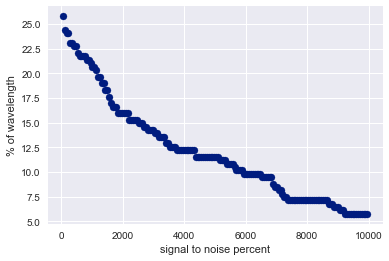

In [123]:
plt.scatter(info_df.iloc[:, 1], info_df.iloc[:, 0]);
plt.ylabel('% of wavelength')
plt.xlabel('signal to noise percent')
#plt.title('21.1 Observability for 60 minutes')
#plt.savefig('21.1Observability5.png', format='png', dpi=1200)

In [124]:
info_df2 = pd.DataFrame(list1)
info_df2.insert(1, '1', list2)

Text(0.5,1,'21.1 Observability with 1% threshold')

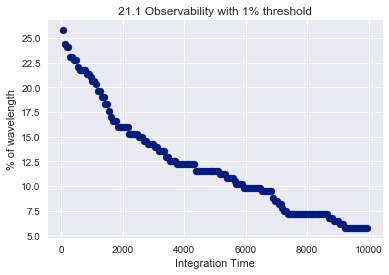

In [125]:
plt.scatter(info_df2.iloc[:, 1], info_df2.iloc[:, 0]);
plt.ylabel('% of wavelength')
plt.xlabel('Integration Time')
plt.title('21.1 Observability with 1% threshold')
#plt.savefig('21.1Observability5.png', format='png', dpi=1200)

In [211]:
df_obs_calc = pd.DataFrame()
list2 = []
wvl = ['17.1', '19.5', '21.1']
for index, val in enumerate(np.arange(60, 3600, 60)):
    output = observability_calc(wvl, val, 5)
    for ind, wl in enumerate(wvl):
        df_obs_calc[wl+' NP for wavelength '+str(val)] = output.loc[:, wl+' NP for wavelength[%]'].values[:1]
    
    list2.append(val)

In [212]:
temp_df = df_obs_calc.iloc[:, 0::3].T
temp_df.insert(1,'val', list2)

temp_df2 = df_obs_calc.iloc[:, 1::3].T
temp_df2.insert(1,'val', list2)

temp_df3 = df_obs_calc.iloc[:, 2::3].T
temp_df3.insert(1,'val', list2)

In [213]:
temp_df.iloc[:, 0]

17.1 NP for wavelength 60      3.691275
17.1 NP for wavelength 120     3.355705
17.1 NP for wavelength 180     3.355705
17.1 NP for wavelength 240     3.355705
17.1 NP for wavelength 300     3.355705
17.1 NP for wavelength 360     3.355705
17.1 NP for wavelength 420     3.355705
17.1 NP for wavelength 480     3.355705
17.1 NP for wavelength 540     3.355705
17.1 NP for wavelength 600     3.355705
17.1 NP for wavelength 660     2.348993
17.1 NP for wavelength 720     2.348993
17.1 NP for wavelength 780     2.348993
17.1 NP for wavelength 840     2.348993
17.1 NP for wavelength 900     2.348993
17.1 NP for wavelength 960     2.348993
17.1 NP for wavelength 1020    2.013423
17.1 NP for wavelength 1080    2.013423
17.1 NP for wavelength 1140    2.013423
17.1 NP for wavelength 1200    2.013423
17.1 NP for wavelength 1260    2.013423
17.1 NP for wavelength 1320    2.013423
17.1 NP for wavelength 1380    1.677852
17.1 NP for wavelength 1440    1.677852
17.1 NP for wavelength 1500    1.677852


In [214]:
list(range(3))

[0, 1, 2]

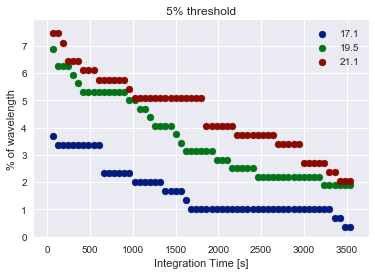

In [215]:
plt.scatter(temp_df.iloc[:, 1], temp_df.iloc[:, 0], label='17.1')
plt.scatter(temp_df2.iloc[:, 1], temp_df2.iloc[:, 0], label='19.5')
plt.scatter(temp_df3.iloc[:, 1], temp_df3.iloc[:, 0], label='21.1')
plt.ylabel('% of wavelength')
plt.xlabel('Integration Time [s]')
plt.title('5% threshold')
plt.legend()
plt.savefig('WLvsIntegrationTime5%.png', format='png', dpi=1200)